In [4]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import string
from unicodedata import normalize
from numpy import array
import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
!python -m pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 9.9 MB/s 
     |████████████████████████████████| 462 kB 53.1 MB/s 


In [5]:
def load_data(source_file, target_file):
  source_sen = []
  target_sen = []
  with open(source_file,encoding="unicode_escape") as file1, open(target_file,encoding="unicode_escape") as file2:
      for fl1, fl2 in zip(file1, file2):
          fl1 = fl1.replace("\n", " ")
          fl1 = fl1.strip()        
          fl2 = fl2.replace(",", " ")
          fl2 = fl2.replace("\n", " ")
          fl2 = fl2.strip()
          source_sen.append(fl1)
          target_sen.append(fl2)
  return target_sen,source_sen

In [7]:
source_file = "/content/sample_data/sentencesTrain.txt"
target_file = "/content/sample_data/tokensTrain.txt"
targ, inp = load_data(source_file, target_file)


In [8]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'When did you graduate high school?'
 b"No, I'm going to Hawaii for spring break."
 b'If the horses play all day on the farm, by nighttime they will be exhausted.'
 b"No, I wasn't old enough to vote at that time."
 b'Where did Sue move to?'], shape=(5,), dtype=string)

tf.Tensor(
[b'IX-2p GRADUATE #HS WHEN GRADUATE WHEN'
 b'wave no IX-1p GO-OUT HANDSOME/ns-HAWAII_2+ FOR SPRING TAKE-BREAK SPRING TAKE-BREAK'
 b'#IF (2h)HORSE IX-loc:i PLAY+ ALL-DAY horse galloping ON FARM GUARANTEE NIGHT TIME+ EXHAUST (2h)HORSE PLAY+ ALL-DAY horse galloping ON GUARANTEE NIGHT TIME+ EXHAUST'
 b'#NO+ IX-1p NOT OLD ENOUGH TO/UNTIL VOTE THAT TIME part:indef ENOUGH TO/UNTIL VOTE TIME part:indef'
 b'fs-SUE IX-3p:i MOVE WHERE++ MOVE'], shape=(5,), dtype=string)


In [10]:
example_text = tf.constant('¿Todavía está en casa?')

In [11]:
def tf_lower_v3(text):
  text = tf.strings.join(['[Begin]', text, '[End]'], separator=' ')
  return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_v3(example_text).numpy().decode())

¿Todavía está en casa?
[Begin] ¿Todavía está en casa? [End]


In [13]:
max_vocab_size = 6000
input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_v3,
    max_tokens=max_vocab_size)

In [14]:
input_text_processor.adapt(inp)
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[End]', '[Begin]', 'the', 'I', 'to', 'If', 'a', 'is']

In [15]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_v3,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[End]',
 '[Begin]',
 'IX-1p',
 'FRIEND',
 'IX-3p:i',
 'part:indef',
 'IX-loc:i',
 '(1h)part:indef']

In [16]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  3,  23,  36,  13, 400, 182, 264,   2,   0,   0],
       [  3,  25,  41,  52,   6, 794,  31, 526, 729,   2],
       [  3,   7,   4, 386,  77,  48, 419,  30,   4, 681]])>

In [17]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[Begin] When did you graduate high school? [End]          '

In [18]:
embedding_dim = 128
units = 1024

In [19]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))
    return output, state

In [22]:

example_tokens = input_text_processor(example_input_batch)

encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

In [21]:

class ShapeChecker():
  def __init__(self):
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [23]:

example_tokens = input_text_processor(example_input_batch)

encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)


In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))


    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [26]:
attention_layer = BahdanauAttention(units)

In [27]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

In [28]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [29]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.attention = BahdanauAttention(self.dec_units)
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [30]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [31]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))


  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)


  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [32]:
Decoder.call = call

In [33]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [35]:

example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[Begin]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:

dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),state = example_enc_state
)


logits shape: (batch_size, t, output_vocab_size) (64, 1, 1294)
state shape: (batch_size, dec_units) (64, 1024)


In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['REMEMBER+'],
       ['RECENT-PAST'],
       ['#CLUB'],
       ['PIZZA_4'],
       ['1p-INFORM:i']], dtype='<U33')

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['HUNGRY/WISH'],
       ['PEOPLE'],
       ['TWO'],
       ['ARRIVE'],
       ['(1h)SECOND-IN-LIST']], dtype='<U33')

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))


    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    return tf.reduce_sum(loss)

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()

    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))


  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

In [ ]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)


translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
np.log(output_text_processor.vocabulary_size())

7.165493475060845

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True

In [ ]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.6397886>}

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.609764>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.556749>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.4090767>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.8593884>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.921364>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.194613>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.4171195>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.395831>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2086835>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9818525>}

CPU times: user 2min 45s, sys: 1.68 s, total: 2min 47s
Wall time: 1min 32s


....................................................................................................


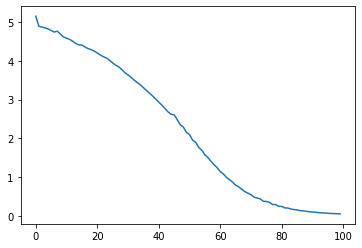

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=30,
                     callbacks=[batch_loss])

Epoch 1/30
11/11 [==============================] - 103s 9s/step - batch_loss: 3.5706
Epoch 2/30
11/11 [==============================] - 106s 10s/step - batch_loss: 3.2433
Epoch 3/30
11/11 [==============================] - 105s 10s/step - batch_loss: 2.9512
Epoch 4/30
11/11 [==============================] - 102s 9s/step - batch_loss: 2.6553
Epoch 5/30
11/11 [==============================] - 103s 9s/step - batch_loss: 2.3423
Epoch 6/30
11/11 [==============================] - 108s 10s/step - batch_loss: 2.1134
Epoch 7/30
11/11 [==============================] - 108s 10s/step - batch_loss: 1.8711
Epoch 8/30
11/11 [==============================] - 110s 10s/step - batch_loss: 1.6297
Epoch 9/30
11/11 [==============================] - 106s 9s/step - batch_loss: 1.4236
Epoch 10/30
11/11 [==============================] - 101s 9s/step - batch_loss: 1.2329
Epoch 11/30
11/11 [==============================] - 108s 10s/step - batch_loss: 1.0674
Epoch 12/30
11/11 [===========================

Text(0, 0.5, 'CE/token')

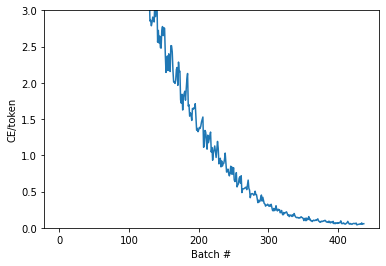

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'(1h)NOW+AFTERNOON_2 SISTER', b'REQUEST READ+',
       b'(2h)LOOK (2h)alt.EAT+', b'missing LETTER/MAIL', b'GRASS MOVIE_2'],
      dtype=object)

In [ ]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Translator.sample = sample

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1159],
       [ 217],
       [ 890],
       [1087],
       [1108]])>

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)


    done = done | (new_tokens == self.end_token)

    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)


    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [ ]:
Translator.translate = translate_unrolled

In [ ]:
test_file = "sentencesTest.txt"
out_file = "output.txt"
out = open(out_file, "w")

with open(test_file,encoding="unicode_escape" ) as f:
    lines = f.read().split("\n")[:-1]

for s in lines:
    data_lst = []
    data_lst.append(s)
    txt = tf.constant(data_lst)
    result = translator.translate(txt = txt)
    translated = result['text'][0].numpy().decode()
    translated = translated.replace(" ", ",")   
    out.write(translated+'\n')

out.close()